In [1]:
from __future__ import print_function

In [2]:
from glob import glob
import numpy as np
import sys, os, h5py, time, errno, random
import GPUtil
import MDAnalysis as mda
from sklearn.cluster import DBSCAN

from CVAE import CVAE 
from utils import start_rabbit, start_worker, start_flower_monitor, read_h5py_file, cm_to_cvae, job_on_gpu
from utils import find_frame, write_pdb_frame, make_dir_p, outliers_from_cvae
from utils import omm_job, cvae_job, job_list 

Using TensorFlow backend.


In [3]:
GPU_ids = [gpu.id for gpu in GPUtil.getGPUs()] 
print('Available GPUs', GPU_ids) 

Available GPUs [0, 1]


In [4]:
top_file = None
pdb_file = os.path.abspath('./pdb/100-fs-peptide-400K.pdb')

In [5]:
# number of cvae jobs 
n_cvae = 2

# logs for scheudler

In [6]:
work_dir = os.path.abspath('./')
log_dir = os.path.join(work_dir, 'scheduler_logs') 
make_dir_p(log_dir)

In [7]:
rabbitmq_log = os.path.join(log_dir, 'rabbit_server_log.txt') 
start_rabbit(rabbitmq_log)
time.sleep(5)

celery_worker_log = os.path.join(log_dir, 'celery_worker_log.txt') 
start_worker(celery_worker_log)
start_flower_monitor() 
print('Waiting 10 seconds for the server to stablize.')
time.sleep(10)

Waiting 10 seconds for the server to stablize.


## Jobs
* Assign job_id according to the available GPUs on the board. 
* Start the simulation according the job_labels containing job_id and gpu_id for individual jobs 

In [8]:
jobs = job_list()

In [9]:
for gpu_id in GPU_ids: 
    job = omm_job(job_id=int(time.time()), gpu_id=gpu_id, top_file=top_file, pdb_file=pdb_file)
    job.start()
    print('haha')
    jobs.append(job) 
    time.sleep(2)

haha
haha


In [10]:
jobs

[<utils.omm_job at 0x7f793822d6d0>, <utils.omm_job at 0x7f79381b6d90>]

# Read the output h5 files

In [11]:
print('Waiting 5 mins for omm to write contact map .h5 files. ')
time.sleep(120)

Waiting 5 mins for omm to write contact map .h5 files. 


In [12]:
cm_files = sorted(glob('omm*/*_cm.h5')) 

cm_data_lists = [read_h5py_file(cm_file) for cm_file in cm_files] 

In [13]:
cm_files

['omm_run_1543441282/output_cm.h5',
 'omm_run_1543869635/output_cm.h5',
 'omm_run_1543869637/output_cm.h5',
 'omm_run_1543955163/output_cm.h5',
 'omm_run_1543955165/output_cm.h5',
 'omm_run_1543955875/output_cm.h5',
 'omm_run_1543955877/output_cm.h5',
 'omm_run_1543956978/output_cm.h5',
 'omm_run_1543956980/output_cm.h5']

# Get updates from h5 file
Once every minute

In [14]:
frame_number = lambda lists: sum([cm.shape[1] for cm in lists])
frame_number(cm_data_lists)

72669

In [15]:
frame_marker = 0 
while frame_number(cm_data_lists) < 500: 
    for cm in cm_data_lists: 
        cm.refresh() 
    if frame_number(cm_data_lists) > frame_marker: 
        print('Current number of frames from OpenMM:', frame_number(cm_data_lists)) 
        frame_marker = int((100 + frame_marker) / 100) * 100
        print('    Next report at frame', frame_marker) 
#     time.sleep(600)

# All contact to h5

In [16]:
train_data_length = [ cm_data.shape[1] for cm_data in cm_data_lists]

omm_log = os.path.join(log_dir, 'openmm_log.txt') 

log = open(omm_log, 'w') 

for i, n_frame in enumerate(train_data_length): 
    log.writelines("{} {}\n".format(cm_files[i], n_frame))    
log.close()

In [17]:
cvae_input = cm_to_cvae(cm_data_lists)

cvae_input_dir = os.path.join(work_dir, 'cvae_input') 
make_dir_p(cvae_input_dir)

cvae_input_file = os.path.join(cvae_input_dir, 'cvae_input.h5')
cvae_input_save = h5py.File(cvae_input_file, 'w')
cvae_input_save.create_dataset('contact_maps', data=cvae_input)
cvae_input_save.close() 

In [18]:
cvae_input.shape

(72669, 22, 22, 1)

# CVAE

In [19]:
hyper_dims = np.arange(n_cvae) + 3

In [20]:
# cvae_jobs = []
for i in np.arange(n_cvae): 
    cvae_j = cvae_job(time.time(), i, cvae_input_file, hyper_dim=i+3) 
    stop_jobs = jobs.get_job_from_gpu_id(i) 
    stop_jobs.stop()  
    time.sleep(2)
#     print('hehre')
    cvae_j.start() 
    jobs.append(cvae_j) 
#     cvae_jobs.append(cvae_j)
    time.sleep(2)

In [21]:
os.path.isfile(cvae_j.model_weight)

False

In [22]:
while [os.path.isfile(cvae_j.model_weight) for cvae_j in jobs.get_cvae_jobs()] != [True] * len(jobs.get_cvae_jobs()): 
    time.sleep(.5)
print('CVAE done. ') 

CVAE done. 


In [23]:
for cvae_j in jobs.get_cvae_jobs(): 
    cvae_j.state = 'FINISHED'

In [24]:
jobs.get_running_jobs()

[]

In [25]:
jobs

# CVE result

# Identifier base on CVAE result

In [26]:
# All the outliers from cvae
print('Counting outliers') 
model_weights = [cvae_j.model_weight for cvae_j in jobs.get_cvae_jobs()]
outlier_list = []
for model_weight in model_weights: 
    print('Model latent dimension: ', int(model_weight[11]))
    for eps in np.arange(0.20, 2.0, 0.05): 
        outliers = np.squeeze(outliers_from_cvae(model_weight, cvae_input, hyper_dim=int(model_weight[11]), eps=eps))
        n_outlier = len(outliers)
        print('dimension = {0}, eps = {1:.2f}, number of outlier found: {2}'.format(
            model_weight[11], eps, n_outlier))
        if n_outlier <= 50: 
            outlier_list.append(outliers)
            break

# np.save('outlier_list.npy', np.array(outlier_list))
outlier_list_uni = np.unique(np.hstack(outlier_list)) 

Counting outliers
Model latent dimension:  3
dimension = 3, eps = 0.20, number of outlier found: 115
dimension = 3, eps = 0.25, number of outlier found: 36
Model latent dimension:  4
dimension = 4, eps = 0.20, number of outlier found: 6196
dimension = 4, eps = 0.25, number of outlier found: 1779
dimension = 4, eps = 0.30, number of outlier found: 506
dimension = 4, eps = 0.35, number of outlier found: 153
dimension = 4, eps = 0.40, number of outlier found: 76
dimension = 4, eps = 0.45, number of outlier found: 33


In [45]:
print('Writing pdb files') 
# write the pdb according the outlier indices
traj_info = open('./scheduler_logs/openmm_log.txt', 'r').read().split()

traj_dict = dict(zip(traj_info[::2], np.array(traj_info[1::2]).astype(int)))

outliers_pdb_path = os.path.join(work_dir, 'outlier_pdbs')
make_dir_p(outliers_pdb_path)

# outliers_list_file = os.path.join(outliers_pdb_path, 'outlier_list.txt') 
outlier_pdb_files = []
for outlier in outlier_list_uni: 
    traj_file, num_frame = find_frame(traj_dict, outlier) 
    print('Found outlier# {} at frame {} of {}'.format(outlier, num_frame, traj_file))
    outlier_pdb_file = os.path.join(outliers_pdb_path, '{}_{}.pdb'.format(traj_file[:18], num_frame))
    outlier_pdb = write_pdb_frame(traj_file, pdb_file, num_frame, outlier_pdb_file) 
    outlier_pdb_files.append(outlier_pdb_file) 

Writing pdb files
Found outlier# 1064 at frame 1064 of omm_run_1543441282/output.dcd
Found outlier# 1162 at frame 1162 of omm_run_1543441282/output.dcd
Found outlier# 1167 at frame 1167 of omm_run_1543441282/output.dcd
Found outlier# 1645 at frame 1645 of omm_run_1543441282/output.dcd
Found outlier# 4625 at frame 4625 of omm_run_1543441282/output.dcd
Found outlier# 5342 at frame 5342 of omm_run_1543441282/output.dcd
Found outlier# 5353 at frame 5353 of omm_run_1543441282/output.dcd
Found outlier# 5354 at frame 5354 of omm_run_1543441282/output.dcd
Found outlier# 5355 at frame 5355 of omm_run_1543441282/output.dcd
Found outlier# 5358 at frame 5358 of omm_run_1543441282/output.dcd
Found outlier# 6683 at frame 6683 of omm_run_1543441282/output.dcd
Found outlier# 6695 at frame 6695 of omm_run_1543441282/output.dcd
Found outlier# 6697 at frame 6697 of omm_run_1543441282/output.dcd
Found outlier# 6710 at frame 6710 of omm_run_1543441282/output.dcd
Found outlier# 6714 at frame 6714 of omm_run

In [28]:
outlier_traj = mda.Universe(outlier_pdb_files[0], outlier_pdb_files)

from MDAnalysis.analysis.rms import RMSD 
RMSD_mat = []
for i in range(outlier_traj.trajectory.n_frames): 
    ref_traj = mda.Universe(outlier_pdb_files[i])
    R = RMSD(outlier_traj, ref_traj, select = 'protein and name CA') 
    R.run()
    RMSD_mat.append(R.rmsd[:,2])

import matplotlib.pyplot as plt
plt.imshow(RMSD_mat)
plt.savefig('rmsd.png')

/home/hm0/anaconda2/lib/python2.7/site-packages/MDAnalysis/coordinates/base.py:821: UserWarning: Reader has no dt information, set to 1.0 ps
  warnings.warn("Reader has no dt information, set to 1.0 ps")


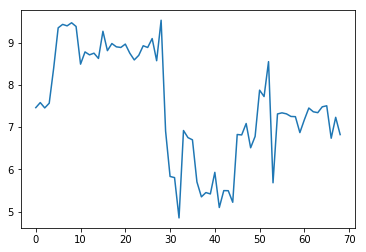

In [29]:
outlier_traj = mda.Universe(outlier_pdb_files[0], outlier_pdb_files)
ref_traj = mda.Universe('./pdb/fs-peptide.pdb')
from MDAnalysis.analysis.rms import RMSD 

R = RMSD(outlier_traj, ref_traj, select = 'protein and name CA') 
R.run()

import matplotlib.pyplot as plt
plt.plot(R.rmsd[:,2])
plt.savefig('rmsd.png')

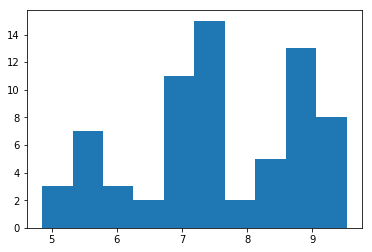

In [30]:
hist, _, _ = plt.hist(R.rmsd[:,2])

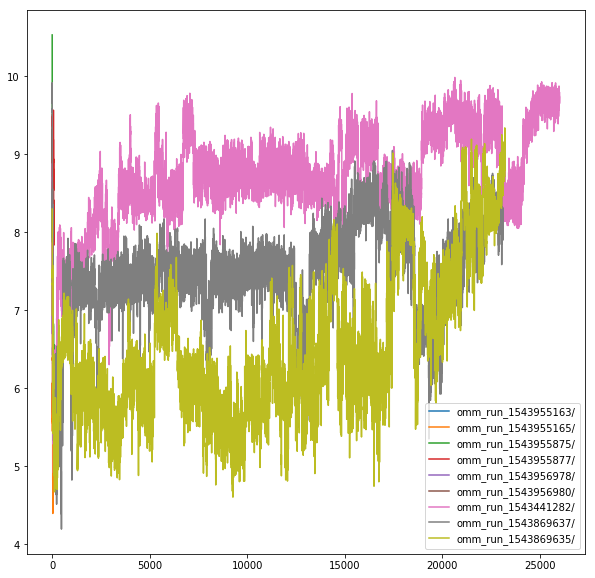

In [31]:
outlier_traj = mda.Universe(outlier_pdb_files[0], 'omm_run_1543441282/output.dcd')
trajs = glob('omm_run*/output.dcd')
ref_traj = mda.Universe('./pdb/fs-peptide.pdb')
from MDAnalysis.analysis.rms import RMSD 
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))

for traj in trajs: 
    mda_traj = mda.Universe(outlier_pdb_files[0], traj)
    R = RMSD(mda_traj, ref_traj, select = 'protein and name CA') 
    R.run()
    ax.plot(R.rmsd[:,2], label=traj[:19])
# plt.scatter(i, R.rmsd[i,2], c='red',s=40)
ax.legend(loc='best')
plt.savefig('rmsd.png')

In [32]:
for gpu_id in jobs.get_available_gpu(GPU_ids): 
    print(gpu_id)

0
1


# start new sims

In [33]:
for gpu_id in jobs.get_available_gpu(GPU_ids): 
    random.shuffle(outlier_pdb_files)
    outlier_pdb_file = outlier_pdb_files[0]
    job = omm_job(job_id=int(time.time()), gpu_id=gpu_id, top_file=top_file, pdb_file=outlier_pdb_file)
    outlier_pdb_files.remove(outlier_pdb_file) 
    job.start()
    print('haha')
    jobs.append(job) 
    time.sleep(2)

haha
haha


# New outliers

In [34]:
time.sleep(120)

In [35]:
cm_files_iter = sorted(glob('omm*/*_cm.h5')) 

for cm_file in cm_files_iter: 
    if cm_file not in cm_files: 
        cm_files.append(cm_file)
        cm_data_lists.append(read_h5py_file(cm_file)) 

In [36]:
for cm in cm_data_lists: 
    cm.refresh() 

In [37]:
frame_number(cm_data_lists)

72848

In [38]:
frame_number(cm_data_lists)

72848

In [39]:
train_data_length = [cm_data.shape[1] for cm_data in cm_data_lists]

log = open(omm_log, 'w') 

for i, n_frame in enumerate(train_data_length): 
    log.writelines("{} {}\n".format(cm_files[i], n_frame))    
log.close()

In [40]:
cvae_input = cm_to_cvae(cm_data_lists)

In [41]:
cvae_input.shape

(72848, 22, 22, 1)

In [42]:
# All the outliers from cvae
print('Counting outliers') 
model_weights = [cvae_j.model_weight for cvae_j in jobs.get_cvae_jobs()]
outlier_list = []
for model_weight in model_weights: 
    print('Model latent dimension: ', int(model_weight[11]))
    for eps in np.arange(0.20, 2.0, 0.05): 
        outliers = np.squeeze(outliers_from_cvae(model_weight, cvae_input, hyper_dim=int(model_weight[11]), eps=eps))
        n_outlier = len(outliers)
        print('dimension = {0}, eps = {1:.2f}, number of outlier found: {2}'.format(
            model_weight[11], eps, n_outlier))
        if n_outlier <= 50: 
            outlier_list.append(outliers)
            break

np.save('outlier_list.npy', np.array(outlier_list))
outlier_list_uni, outlier_count = np.unique(np.hstack(outlier_list), return_counts=True) 
# outlier_list_ulti = outlier_list_uni[np.where(outlier_count > 1)]
# print('outliers: ', outlier_list_ulti)

Counting outliers
Model latent dimension:  3
dimension = 3, eps = 0.20, number of outlier found: 115
dimension = 3, eps = 0.25, number of outlier found: 36
Model latent dimension:  4
dimension = 4, eps = 0.20, number of outlier found: 6197
dimension = 4, eps = 0.25, number of outlier found: 1777
dimension = 4, eps = 0.30, number of outlier found: 506
dimension = 4, eps = 0.35, number of outlier found: 153
dimension = 4, eps = 0.40, number of outlier found: 76
dimension = 4, eps = 0.45, number of outlier found: 33


In [43]:
print('Writing pdb files') 
# write the pdb according the outlier indices
traj_info = open('./scheduler_logs/openmm_log.txt', 'r').read().split()

traj_dict = dict(zip(traj_info[::2], np.array(traj_info[1::2]).astype(int)))

break_loop = False
for outlier in outlier_list_uni:
    traj_file, num_frame = find_frame(traj_dict, outlier)    
    outlier_pdb_file = os.path.join(outliers_pdb, '{}_{}.pdb'.format(traj_file[:18], num_frame))
#     if outlier_pdb_file not in outlier_pdb_files:
# print('Found outlier# {} at frame {} of {}'.format(outlier, num_frame, traj_file))
#         outlier_pdb = write_pdb_frame(traj_file, pdb_file, num_frame, outlier_pdb_file)
#         outlier_pdb_files.append(outlier_pdb_file)
#         break_loop = True

Writing pdb files
